In [1]:
import pandas as pd
from biom import load_table
import matplotlib.pyplot as plt
import numpy as np
from skbio import TreeNode
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
from pls_balances.src.sim import chain_interactions
gradient = np.linspace(0, 50, 100)
mu = np.array([10, 15, 35, 40])
sigma = np.array([4]*len(mu))
microbial_truth = chain_interactions(gradient, mu, sigma)

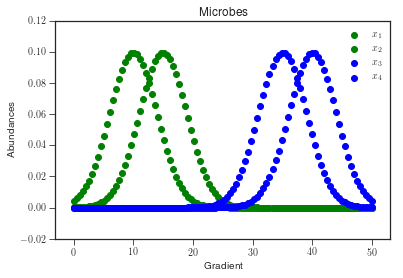

In [3]:
fig, ax = plt.subplots()
ax.scatter(gradient, microbial_truth[:, 0], label=r'$x_1$', c='g')
ax.scatter(gradient, microbial_truth[:, 1], label=r'$x_2$', c='g')
ax.scatter(gradient, microbial_truth[:, 2], label=r'$x_3$', c='b')
ax.scatter(gradient, microbial_truth[:, 3], label=r'$x_4$', c='b')

ax.set_title('Microbes')
ax.set_ylabel('Abundances')
ax.set_xlabel('Gradient')
ax.legend()
fig.savefig('../results/figures/figure_1a.pdf')

In [4]:
from skbio.stats.composition import closure
from pls_balances.src.sim import compositional_noise
from numpy.random import RandomState
from skbio.stats.composition import perturb

# force closure to 1
microbial_table = closure(microbial_truth)
rng = RandomState(0)
cov = np.eye(3)

# add compositional nose
m_noise = compositional_noise(cov, nsamp=len(gradient), rng=rng)
microbial_table = np.vstack([
    perturb(microbial_table[i, :], m_noise[i, :])
    for i in range(len(gradient))])

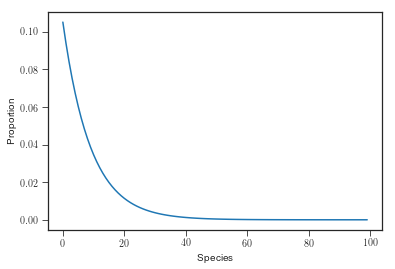

In [5]:
from scipy.stats import expon
fig, ax = plt.subplots()

x = np.linspace(0, 11, 100)
contaminant_urn = closure(expon.pdf(x))
plt.plot(contaminant_urn)
plt.xlabel('Species')
plt.ylabel('Proportion')
fig.savefig('../results/figures/figure_s1a.pdf')

In [6]:
contaminant_urns = np.repeat(np.expand_dims(contaminant_urn, axis=0),
                             microbial_table.shape[0], axis=0)
microbial_table = np.hstack((microbial_table, contaminant_urns))
microbial_table = closure(microbial_table)

In [7]:
from pls_balances.src.sim import multinomial_sample
from scipy.stats import norm, poisson
seq_depths = poisson.rvs(10000, size=microbial_table.shape[0], random_state=0)

microbial_table = multinomial_sample(microbial_table, seq_depths)

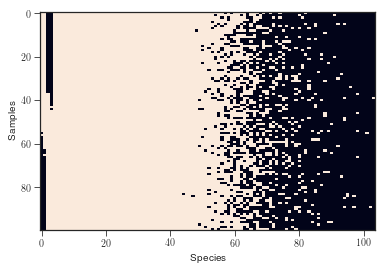

In [8]:
fig = plt.figure()
plt.imshow(microbial_table>0, aspect='auto', interpolation='nearest')
plt.xlabel('Species')
plt.ylabel('Samples')
fig.savefig('../results/figures/figure_1b.pdf')

In [9]:
sample_ids = ["S%d" % i for i in range(microbial_table.shape[0])]
microbial_table = pd.DataFrame(microbial_table, index=sample_ids)
intercept = np.array([0] * len(gradient))
group = np.array([0]*50 + [1]*50)
metadata = pd.DataFrame({'Intercept': intercept,
                         'Group': group,
                         'Gradient': gradient}, index=sample_ids)

# Balance classifer

In [10]:
def solve(w1, w2, m1, m2, std1, std2):
    # from stackoverflow
    # https://stackoverflow.com/a/22579904/1167475
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log((w1/w2) * np.sqrt(std2/std1))
    return np.roots([a,b,c])

def reorder(mid, m):
    lookup = {0: [1, 2], 1: [0, 2], 2: [0, 1]}
    l, r = lookup[mid]
    if m[l] > m[r]:
        l, r = r, l
    return l, mid, r

def round_balance(spectrum):
    gmod = GaussianMixture(n_components=3)
    gmod.fit(X=spectrum)
    m = gmod.means_
    std = np.sqrt(np.ravel(gmod.covariances_))
    w = gmod.weights_

    # first identify the distribution closest to zero
    mid = np.argmin(np.abs(m))

    # solve for intersections closest to zero
    l, mid, r = reorder(mid, m)
    lsol = solve(w[mid], w[l], m[mid], m[l], std[mid], std[l])
    rsol = solve(w[mid], w[r], m[mid], m[r], std[mid], std[r])

    lsol = lsol[np.argmin(np.abs(lsol))]
    rsol = rsol[np.argmin(np.abs(rsol))]    
    #lsol, rsol = m[l][0], m[r][0]
    return lsol, rsol

In [11]:
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize, multiplicative_replacement

ctable = pd.DataFrame(microbial_table+1,
                      index=microbial_table.index, 
                      columns=microbial_table.columns)
ctable = pd.DataFrame(clr(centralize(microbial_table+1)),
                      index=microbial_table.index, 
                      columns=microbial_table.columns)

rfc = PLSRegression(n_components=2)
rfc.fit(X=ctable.values, Y=metadata.Group)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

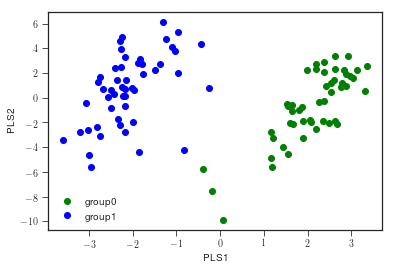

In [12]:
fig = plt.figure()

midx = (metadata.Group==0).values
lidx = (metadata.Group==1).values
plt.plot(rfc.x_scores_[midx, 0], rfc.x_scores_[midx, 1], 'og', label='group0')
plt.plot(rfc.x_scores_[lidx, 0], rfc.x_scores_[lidx, 1], 'ob', label='group1')
plt.xlabel('PLS1')
plt.ylabel('PLS2')
plt.legend(loc=3)
fig.savefig('../results/figures/figure_1c.pdf')

In [13]:
rfc = PLSRegression(n_components=1)
rfc.fit(X=ctable.values, Y=metadata.Group==0)

PLSRegression(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

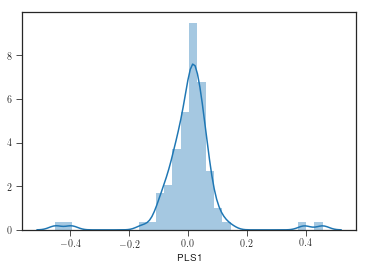

In [14]:
pls_df = pd.DataFrame(rfc.x_weights_, index=ctable.columns, columns=['PLS1'])
sns.distplot(pls_df.PLS1)

In [15]:
from sklearn.mixture import GaussianMixture
gmod = GaussianMixture(n_components=3, random_state=1)
gmod.fit(X=pls_df.values)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=1, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [16]:
m = np.ravel(gmod.means_)
s = np.ravel(np.sqrt(gmod.covariances_)) 
w = np.ravel(gmod.weights_)

In [17]:
m

array([ 0.00551861,  0.42686446, -0.42239211])

/Users/mortonjt/miniconda3/envs/pls-balances/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


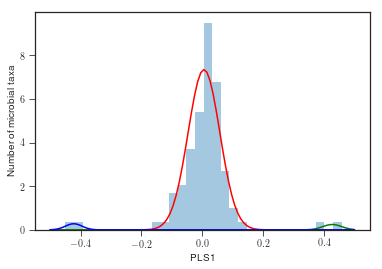

In [18]:
from scipy.stats import norm
fig = plt.figure()
x = np.linspace(-0.5, 0.5, 100)
sns.distplot(pls_df.PLS1, norm_hist=True, kde=False)
plt.plot(x, w[0]*norm.pdf(x, m[0], s[0]), '-r')
plt.plot(x, w[1]*norm.pdf(x, m[1], s[1]), '-g')
plt.plot(x, w[2]*norm.pdf(x, m[2], s[2]), '-b')
plt.legend()
plt.ylabel('Number of microbial taxa')
fig.savefig('../results/figures/figure_1d.pdf')

In [19]:
l, r = round_balance(pls_df.values)

In [20]:
denom = pls_df.loc[pls_df.PLS1 < l]
num = pls_df.loc[pls_df.PLS1 > r]

In [21]:
pls_balance = (np.log(microbial_table.loc[:, num.index] + 1).mean(axis=1) - 
               np.log(microbial_table.loc[:, denom.index] + 1).mean(axis=1))

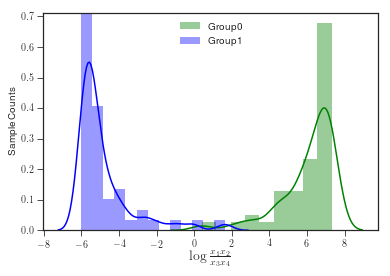

In [22]:
y = 'pls_balance'
fig = plt.figure()
sns.distplot(pls_balance[metadata.Group==0], label=r'Group0', color='g')
sns.distplot(pls_balance[metadata.Group==1], label=r'Group1', color='b')
plt.ylabel('Sample Counts')
plt.legend()
plt.xlabel(r'$\log \frac{x_1 x_2}{x_3 x_4}$', fontsize=14)
fig.savefig('../results/figures/figure_1e.pdf')

In [23]:
denom

,PLS1
2,-0.395209
3,-0.449575
43,-0.155103


In [24]:
num

,PLS1
0,0.457967
1,0.395762
